# The applications of linear algebra on Recommender systems

## Setup

### Build

In [1]:
# !just build

### Modules

In [2]:
# Our module
import alglin_python as alin

# Data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Case recomender
from caserec.recommenders.rating_prediction.most_popular import MostPopular
from caserec.recommenders.rating_prediction.itemknn import ItemKNN

# Data visualization
import matplotlib.pyplot as plt

# Other
import os
import tarfile
import urllib.request
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### Dowloading the dataset

In [3]:
# Helper function to download and extract a file
def download_and_extract(url, target_folder=None):
    """ Downloads a file from a given URL and extracts it if necessary. """
    # Extract file name from URL
    file_name = os.path.basename(url)
    
    # Determine extraction folder name
    if target_folder is None:
        target_folder = os.path.splitext(file_name)[0]
    
    # Check if the file is already downloaded
    if not os.path.exists(file_name):
        print(f"Downloading {file_name}...")
        urllib.request.urlretrieve(url, file_name)
        print(f"Downloaded {file_name}.")
    else:
        print(f"{file_name} already exists, skipping download.")
    
    # Check if the folder is already extracted
    if not os.path.exists(target_folder):
        print(f"Extracting {file_name}...")
        with tarfile.open(file_name, "r:gz") as tar:
            tar.extractall()
        print(f"Extraction completed.")
    else:
        print(f"{target_folder} already exists, skipping extraction.")


# Download and extract the dataset
dataset_url = "https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz"

download_and_extract(dataset_url)


ml-20m-compact.tar.gz already exists, skipping download.
Extracting ml-20m-compact.tar.gz...
Extraction completed.


In [4]:
# If the download is not working, you can try this:
# !python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
# !tar -xvzf ml-20m-compact.tar.gz

### Loading the dataset

In [5]:
pd.read_csv('./dataset/movies_sample.csv')

,movieId,title,genres
0,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime|Drama
1,31,Dangerous Minds (1995),Drama
2,37,Across the Sea of Time (1995),Documentary|IMAX
3,161,Crimson Tide (1995),Drama|Thriller|War
4,193,Showgirls (1995),Drama
...,...,...,...
428,129857,Bright Days Ahead (2013),Drama|Romance
429,130344,Coast of Death (2013),Children|Documentary|Drama
430,130408,A Rumor Of War (1980),(no genres listed)
431,130510,Berserk: The Golden Age Arc 3 - Descent (2013),Action|Animation|Fantasy


In [6]:
pd.read_csv('./dataset/ratings_sample.csv')

,userId,movieId,rating,timestamp
0,11,7481,5.0,1230788624
1,11,1046,4.5,1251144145
2,11,616,4.0,1230782542
3,11,3535,2.0,1230784884
4,11,5669,5.0,1230853788
...,...,...,...,...
190616,138493,288,5.0,1255808026
190617,138493,1748,5.0,1255805576
190618,138493,616,4.0,1256750556
190619,138493,1597,4.5,1255817426


In [7]:
# Loading data
movies_df = pd.read_csv('./dataset/movies_sample.csv')
ratings_df = pd.read_csv('./dataset/ratings_sample.csv')

# Extract unique users and movies
all_users = ratings_df['userId'].unique()
all_movies = pd.concat([ratings_df['movieId'], movies_df['movieId']]).unique()

# Mapping users and movies to indices
map_users = {user: idx for idx, user in enumerate(all_users)}
map_items = {item: idx for idx, item in enumerate(all_movies)}

# Apply the mappings directly
ratings_df['userId'] = ratings_df['userId'].map(map_users)
ratings_df['movieId'] = ratings_df['movieId'].map(map_items)
movies_df['movieId'] = movies_df['movieId'].map(map_items)

# Drop unnecessary columns
movies_df = movies_df.drop(columns=['title'])

# Prepare mapped arrays for future use
all_movies = np.arange(len(all_movies))  # Mapped movie IDs
all_users = np.arange(len(all_users))   # Mapped user IDs

## Helper Functions

In [8]:
def evaluate_predictions(predictions, ground_truth, silent=False):
    """
    Evaluates the predictions against ground truth using RMSE, MAE, and R² metrics.
    
    Parameters:
    - predictions: pandas Series or numpy array, predicted ratings.
    - ground_truth: pandas Series or numpy array, true ratings.
    - silent: bool, if False (default), prints the metrics. If True, suppresses output.
    
    Returns:
    - metrics: dict, a dictionary containing RMSE, MAE, and R² scores.
    """
    
    rmse = np.sqrt(mean_squared_error(ground_truth, predictions))
    mae = mean_absolute_error(ground_truth, predictions)
    r2 = r2_score(ground_truth, predictions)
    
    metrics = {
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    }
    
    if not silent:
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R²: {r2:.2f}")
    
    return metrics

## Exploration

In [9]:
movies_df.head()

,movieId,genres
0,49,Crime|Drama
1,61,Drama
2,125,Documentary|IMAX
3,23,Drama|Thriller|War
4,56,Drama


In [10]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,0,0,5.0,1230788624
1,0,1,4.5,1251144145
2,0,2,4.0,1230782542
3,0,3,2.0,1230784884
4,0,4,5.0,1230853788


In [11]:
def print_dataset_statistics(df):
    """
    Prints dataset statistics including the number of users, items, interactions, 
    and interaction ratios per user and per item.
    """
    num_users = df['userId'].nunique()
    num_items = df['movieId'].nunique()
    num_interactions = df.shape[0]
    interaction_user_ratio = num_interactions / num_users
    interaction_item_ratio = num_interactions / num_items

    stats_message = f"""
    Number of users: {num_users}
    Number of items: {num_items}
    Number of interactions: {num_interactions}
    Interaction-to-user ratio: {interaction_user_ratio:.2f}
    Interaction-to-item ratio: {interaction_item_ratio:.2f}
    """
    
    print(stats_message)


print_dataset_statistics(ratings_df)


    Number of users: 11090
    Number of items: 417
    Number of interactions: 190621
    Interaction-to-user ratio: 17.19
    Interaction-to-item ratio: 457.12
    


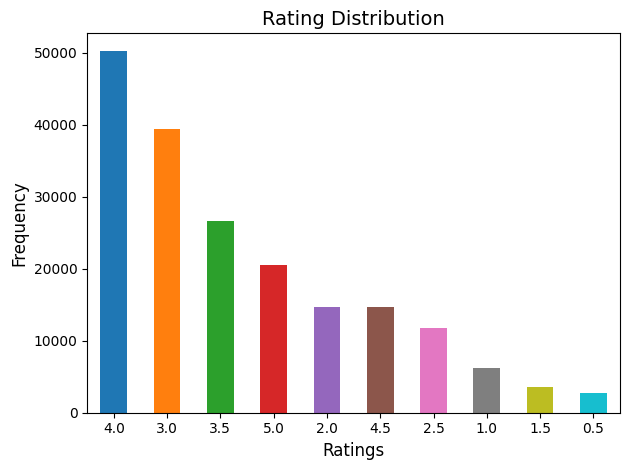

In [12]:
def plot_rating_distribution(ratings, column_name = 'rating', title='Rating Distribution'):
    """ Plots the distribution of ratings in a specified column. """

    # Calculate value counts
    value_counts = ratings[column_name].value_counts()
    
    # Create a bar plot with dynamic colors
    value_counts.plot(kind='bar', color=plt.cm.tab10.colors[:len(value_counts)])
    
    # Add title and axis labels
    plt.title(title, fontsize=14)
    plt.xlabel('Ratings', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # Improve layout and readability
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    
    # Display the plot
    plt.show()

plot_rating_distribution(ratings_df)

### Train-Test split

In [13]:
os.makedirs('cache', exist_ok=True)
cache_path = Path('cache')

train, test = train_test_split(ratings_df, test_size=.2, random_state=2)

train_file = cache_path / 'train.csv'
test_file = cache_path / 'test.csv'

train.to_csv(train_file, index=False, header=False, sep='\t')
test.to_csv(test_file, index=False, header=False, sep='\t')

### Most Popular

In [14]:
mp_pred_file = cache_path / 'out_mp_pred.csv'

if mp_pred_file.exists():
    print("File found. Skipping Most Popular computation")
else:
    MostPopular(train_file, test_file, mp_pred_file).compute()

File found. Skipping Most Popular computation


In [15]:
mp_pred_df = pd.read_csv(mp_pred_file, sep='\t', names=['userId', 'movieId', 'rating'])
mp_pred_df['rounded_rating'] = mp_pred_df['rating'].round()

mp_pred_df.head()

,userId,movieId,rating,rounded_rating
0,0,5,3.340482,3.0
1,0,0,3.462625,3.0
2,1,13,3.501614,4.0
3,1,16,3.075567,3.0
4,1,14,3.654597,4.0


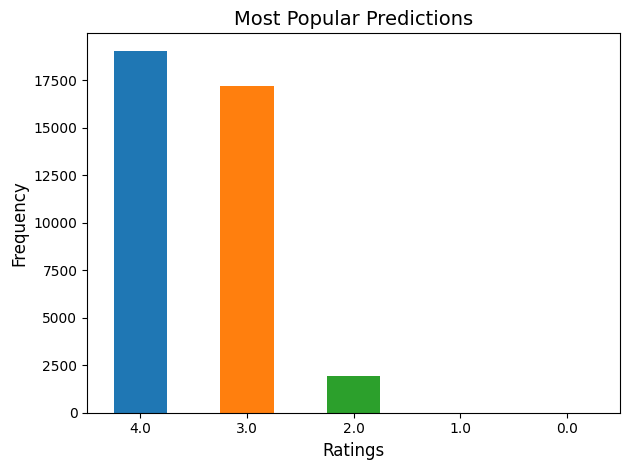

In [16]:
plot_rating_distribution(mp_pred_df, column_name='rounded_rating', title='Most Popular Predictions')

In [17]:
mp_evaluation = evaluate_predictions(mp_pred_df['rating'], test['rating'])

RMSE: 1.16
MAE: 0.91
R²: -0.24


### Item KNN

In [18]:
itemknn_pred_file = cache_path / 'out_itemknn_pred.csv'

if itemknn_pred_file.exists():
    print("File found. Skipping ItemKNN computation")
else:
    ItemKNN(train_file, test_file, itemknn_pred_file).compute()

File found. Skipping ItemKNN computation


In [19]:
itemknn_pred_df = pd.read_csv(itemknn_pred_file, sep='\t', names=['userId', 'movieId', 'rating'])
itemknn_pred_df['rounded_rating'] = itemknn_pred_df['rating'].round()

itemknn_pred_df.head()

,userId,movieId,rating,rounded_rating
0,0,0,4.700316,5.0
1,0,5,4.159026,4.0
2,1,13,4.891167,5.0
3,1,14,5.000000,5.0
4,1,16,3.885790,4.0


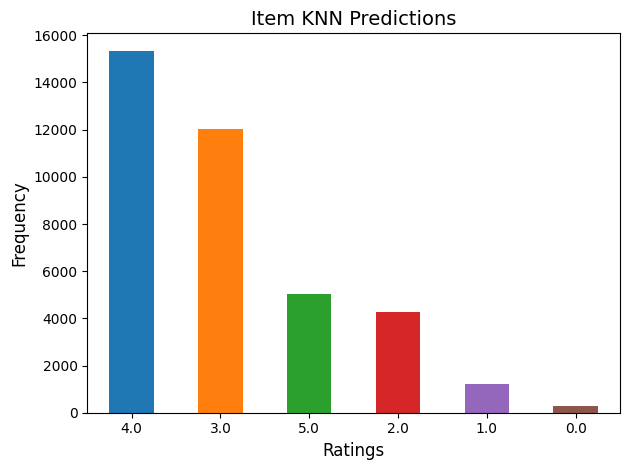

In [20]:
plot_rating_distribution(itemknn_pred_df, column_name='rounded_rating', title='Item KNN Predictions')

In [21]:
itemknn_evaluation = evaluate_predictions(itemknn_pred_df['rating'], test['rating'])

RMSE: 1.40
MAE: 1.11
R²: -0.83


### SVD++ 

In [22]:
ratings_sample_df = ratings_df.sample(frac=0.001, random_state=42)

sample_user_mapping = {user: idx for idx, user in enumerate(ratings_sample_df['userId'].unique())}
sample_item_mapping = {item: idx for idx, item in enumerate(ratings_sample_df['movieId'].unique())}

ratings_sample_df['userId'] = ratings_sample_df['userId'].map(sample_user_mapping)
ratings_sample_df['movieId'] = ratings_sample_df['movieId'].map(sample_item_mapping)

# Sample train-test split
sample_train, sample_test = train_test_split(ratings_sample_df, test_size=.2, random_state=2)

ratings_sample_df

,userId,movieId,rating,timestamp
36611,0,0,3.5,1079814338
188442,1,1,4.0,1226813987
77452,2,2,4.0,1389300242
178362,3,3,4.0,1002996477
107132,4,4,1.0,1424129819
...,...,...,...,...
40600,186,77,3.0,1290433858
95449,187,37,1.0,1158239389
57271,188,12,3.0,1126509541
59534,130,7,2.0,1167232232


In [23]:
from alglin_python import svdpp

In [24]:
global_mean, bu, bi, p, q, implicit_factors, error = svdpp.train_svdpp(ratings_sample_df, sample_train, 2, miter=30)

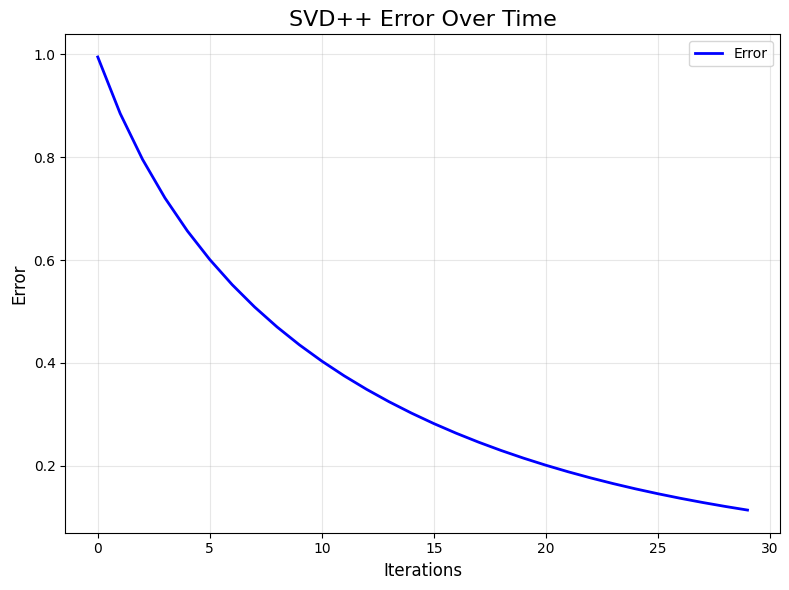

In [25]:
def plot_error(error, title="SVD++ Error Over Time", xlabel="Iterations", ylabel="Error", grid=True):
    """
    Plots the error values with enhancements for better visualization.
    """
    plt.figure(figsize=(8, 6))  # Adjust figure size for better readability
    plt.plot(error, label="Error", color="blue", linewidth=2)  # Customize line appearance
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(fontsize=10)  # Add a legend
    if grid:
        plt.grid(alpha=0.3)  # Add light gridlines for better readability
    plt.tight_layout()  # Ensure no clipping of labels
    plt.show()


plot_error(error)


In [26]:
predictions, actuals = svdpp.evaluate_model_svdpp(sample_train, global_mean, bu, bi, p, q, implicit_factors, test)

for i in range(10):
    print(f'Predicted: {predictions[i]:.2f}, Actual: {actuals[i]:.2f}')

RMSE: 1.0418447278787752
Predicted: 3.42, Actual: 2.50
Predicted: 3.42, Actual: 3.50
Predicted: 3.42, Actual: 4.50
Predicted: 3.42, Actual: 5.00
Predicted: 3.42, Actual: 4.00
Predicted: 4.54, Actual: 3.50
Predicted: 3.42, Actual: 1.00
Predicted: 3.42, Actual: 0.50
Predicted: 3.42, Actual: 3.00
Predicted: 3.42, Actual: 2.50
